In [1]:
from sklearn.datasets import load_boston
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import time

from sklearn import datasets, linear_model
from sklearn import metrics, cross_validation
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

/Users/vijaypatel/miniconda3/envs/py34-learning/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [3]:
type(boston)

sklearn.datasets.base.Bunch

In [4]:
print(boston.DESCR)
print(boston.keys())
print(boston.feature_names)
print(boston.data.shape)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
X = boston.data

In [6]:
X[0:2, :]

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
          0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
          6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
          2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
          4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   6.42100000e+00,
          7.89000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.96900000e+02,
          9.14000000e+00]])

In [7]:
y = boston.target

In [8]:
y[0:2]

array([ 24. ,  21.6])

## Prepare train/test sets

In [9]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.33, random_state = 5)

print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (339, 13)
y_train shape: (339,)
X_test shape: (167, 13)
y_test shape: (167,)


## Define linear regression functions

In [10]:
def predict(X, theta):
    return X.dot(theta.T)

def sum_squared_error(y, y_pred):
    square_of_errors = np.square(y_pred - y)
    return np.sum(square_of_errors)

def mean_squared_error(y, y_pred):
    m = y.shape[0]
    return (1 / (m)) * sum_squared_error(y, y_pred)
    
def gradient(X, y, y_pred):
    m = X.shape[0]
    error = y_pred - y
    gradient = (1/m) * X.T.dot(error)
    return (gradient, error)
    
def gradient_descent(X_y_gen, theta, alpha, iterations):
    for it in range(iterations):
        for X, y in X_y_gen():
            m = X.shape[0]
            y_pred = predict(X, theta)
            grad, error = gradient(X, y, y_pred)
            theta = theta - (alpha * grad)
            
        log_gradient_descent_step(it, theta, error)
            
    return theta

def gradient_descent_stochastic(X_y_gen, theta, alpha, iterations):
    for it in range(iterations):
        for X, y in X_y_gen():
            for i, _ in enumerate(X):
                X_i = X[i]
                y_i = y[i]
                y_i_pred = predict(X_i, theta)
                grad, error = gradient(X_i, y_i, y_i_pred)
                theta = theta - (alpha * grad)

        log_gradient_descent_step(it, theta, error)
        
    return theta


def all_gen(X, y):
    def lazy():
        X_shuf, y_shuf = shuffle(X, y)
        yield (X_shuf, y_shuf)
    return lazy
        
def batch_gen(X, y, batch_size):
    def lazy():
        X_shuf, y_shuf = shuffle(X, y)
        for i in range(0, len(y_shuf), batch_size):
            yield (X_shuf[i:i+batch_size,:], y_shuf[i:i+batch_size])
    return lazy

## Define helper function

In [11]:
def plot_actual_over_predicted(y_actual, y_pred):
    plt.scatter(y_actual, y_pred)
    plt.plot([0, 50], [0, 50], '--k')
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
    plt.show()

def plot_residuals(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    plt.scatter(y_pred_for_X_train, y_pred_for_X_train - y_train, c='b', s=40, alpha=0.5)
    plt.scatter(y_pred_for_X_test, y_pred_for_X_test - y_test, c='g', s=40)
    plt.hlines(y=0, xmin=0, xmax=50)
    plt.title('Residual plot using training (blue) and test (green) data')
    plt.ylabel('Residuals')
    plt.show()
    
def log_gradient_descent_step(it, theta, error):
     if (debug):
        print("Iteration: " + str(it))    
        print("  Theta: " + str(theta))
        print("  Error: " + str(error))
        
def calculate_cost_of_theta(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    mse_on_train = mean_squared_error(y_train, y_pred_for_X_train)
    mse_on_test = mean_squared_error(y_test, y_pred_for_X_test)
    print('Theta: \n', theta)
    print("Mean squared error (train):", mse_on_train)
    print("Mean squared error (test):", mse_on_test)
        
def run_timed(func):
    start = time.clock()
    results = func()
    print("Time taken:", time.clock() - start)
    return results


## Test linear regression on limited data set

In [12]:
debug = True    

t_X = np.array([[1, 2, 3],[4, 5, 6]])
t_y = np.array([6, 15])
t_theta = np.array([2, 1, 1])
print("Theta: " + str(t_theta))

# Test cost function
t_y_pred = predict(t_X, t_theta)
cost = mean_squared_error(t_y, t_y_pred)
print("Cost: " + str(cost))
    
# Test gradient function
g, e = gradient(t_X, t_y, t_y_pred)
print("Gradient: " + str(g))

# Test gradient descent
print("\n")
print("Testing gradient descent")
t_initial_theta = np.array([4,3,2])
optimised_theta = gradient_descent(all_gen(t_X, t_y), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent stochastic
print("\n")
print("Testing gradient descent stochastic")
optimised_theta = gradient_descent_stochastic(all_gen(t_X, t_y), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent(mini batch)
print("\n")
print("Testing gradient descent mini batch")
optimised_theta = gradient_descent(batch_gen(t_X, t_y, 2), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

Theta: [2 1 1]
Cost: 8.5
Gradient: [  8.5  11.   13.5]


Testing gradient descent
Iteration: 0
  Theta: [ 3.39  2.2   1.01]
  Error: [28 10]
Iteration: 1
  Theta: [ 3.0535  1.7613  0.4691]
  Error: [ 15.62   4.82]
Iteration: 2
  Theta: [ 2.866881   1.5205885  0.174296 ]
  Error: [ 1.9834  8.8351]
Iteration: 3
  Theta: [ 2.76240142  1.38837298  0.01434453]
  Error: [ 0.430946   5.1162425]
Iteration: 4
  Theta: [ 2.70293976  1.31561272 -0.07171431]
  Error: [ 3.07753778 -0.41781902]
Iteration: 5
  Theta: [ 2.66815391  1.27543408 -0.11728575]
  Error: [-0.88097773  1.95953678]
Iteration: 6
  Theta: [ 2.64689666  1.25311064 -0.14067537]
  Error: [ 1.34607155 -1.13283518]
Iteration: 7
  Theta: [ 2.63305945  1.24057253 -0.15191438]
  Error: [ 1.00908763 -1.26890816]
Iteration: 8
  Theta: [ 2.62329485  1.23339757 -0.15649972]
  Error: [ 0.8236142  -1.34153861]
Iteration: 9
  Theta: [ 2.61576852  1.22916243 -0.15744365]
  Error: [-1.37940918  0.72116891]
Iteration: 10
  Theta: [ 2.60947522  1.

## Run linear regression (ordinary least squares) from scikit-learn

<b>Provides some results to compare against</b>

Coefficients: 
 [ -1.56381297e-01   3.85490972e-02  -2.50629921e-02   7.86439684e-01
  -1.29469121e+01   4.00268857e+00  -1.16023395e-02  -1.36828811e+00
   3.41756915e-01  -1.35148823e-02  -9.88866034e-01   1.20588215e-02
  -4.72644280e-01]
Mean squared error (train): 19.55
Mean squared error (test): 28.54


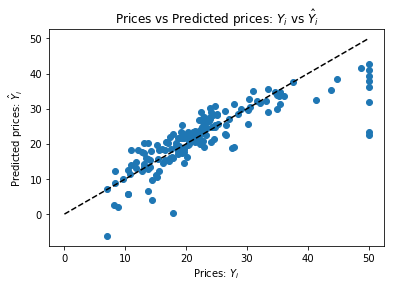

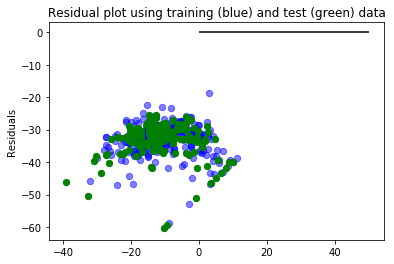

In [13]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error (train): %.2f" % metrics.mean_squared_error(y_train, regr.predict(X_train)))
print("Mean squared error (test): %.2f" % metrics.mean_squared_error(y_test, y_pred))

plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, regr.coef_)

## Run stochastic gradient descent from scikit-learn

Coefficients: 
 [-0.14450113  0.09225679 -0.05058803  0.04138125  0.06109877  1.48289505
  0.08002449 -0.11168592  0.1408739  -0.00777516  0.41568348  0.02466531
 -0.72881115]
Mean squared error (train): 40.89
Mean squared error (test): 50.98


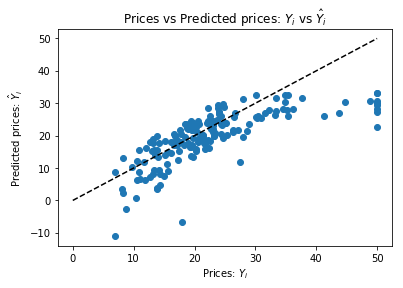

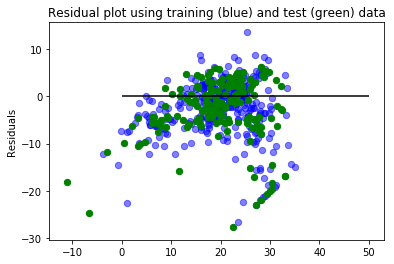

In [14]:
regr = linear_model.SGDRegressor(
    loss="squared_loss", 
    penalty=None, 
    eta0=0.000007,
    n_iter=4000)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error (train): %.2f" % metrics.mean_squared_error(y_train, regr.predict(X_train)))
print("Mean squared error (test): %.2f" % metrics.mean_squared_error(y_test, y_pred))

plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, regr.coef_)

## Run linear regression with gradient descent

Theta: 
 [ 0.82422779  0.72291141  0.79185009  0.13527002  0.90743021  0.85847436
  0.62233375  0.84288275  0.37778671  0.9193925   0.98396536  0.55265196
  0.87341308]
Mean squared error (train): 451295.695918
Mean squared error (test): 461074.790498


Time taken: 21.38397
Theta: 
 [-0.13849141  0.07341839  0.00642847  0.17338232  0.95028178  2.00107658
  0.07639024  0.20252115  0.20762117 -0.00836415  0.21770412  0.02511619
 -0.70242774]
Mean squared error (train): 33.1073327762
Mean squared error (test): 41.6191844127


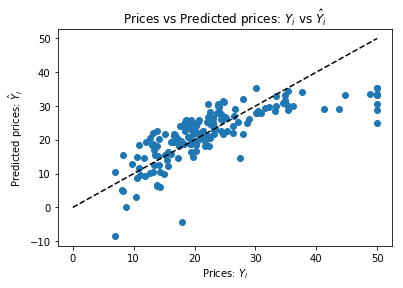

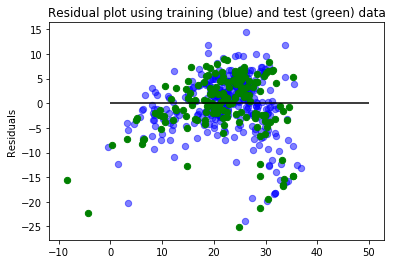

In [15]:
debug = False
num_of_iterations = 100000
alpha = 0.000004 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent(all_gen(X_train, y_train), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

## Run linear regression with stochastic gradient descent

Theta: 
 [ 0.92709606  0.83244478  0.69026393  0.99659864  0.74534234  0.25354052
  0.59551158  0.5288678   0.6967871   0.12658326  0.0576662   0.17812045
  0.87887784]
Mean squared error (train): 32994.1851979
Mean squared error (test): 33897.7964111


Time taken: 7.012564000000001
Theta: 
 [-0.13964014  0.07427435 -0.0186382   1.01767435  0.8177661   2.13767544
  0.06977479  0.06595893  0.18267463 -0.00883413  0.21486615  0.02379346
 -0.68418386]
Mean squared error (train): 33.4083687397
Mean squared error (test): 42.2662152035


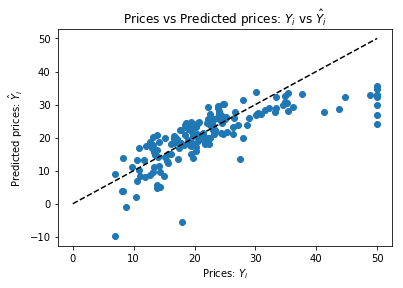

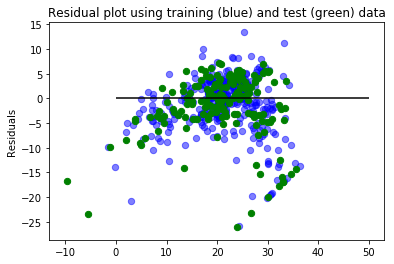

In [16]:
debug = False
num_of_iterations = 3000
alpha = 0.000007 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent_stochastic(all_gen(X_train, y_train), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)


## Run linear regression with mini batch gradient descent

Theta: 
 [  3.58642595e-01   1.75229701e-01   6.25542242e-02   7.83772593e-01
   6.80914814e-01   6.14822569e-04   6.48254243e-01   1.40845848e-01
   8.11588969e-01   6.28527504e-01   6.61370342e-01   4.13258451e-01
   7.60092487e-01]
Mean squared error (train): 224678.107348
Mean squared error (test): 229359.331059


Time taken: 12.366453999999997
Theta: 
 [-0.14982277  0.07178272 -0.05011144  0.84677264  0.82629165  3.48125461
  0.03448443 -0.55245588  0.17945109 -0.0090238   0.04757372  0.01832558
 -0.57224109]
Mean squared error (train): 28.4315053845
Mean squared error (test): 38.2872488914


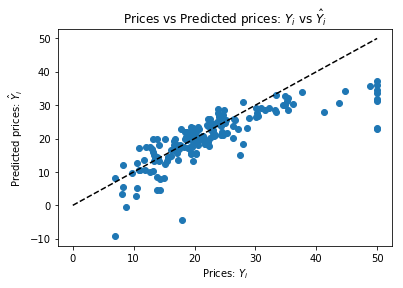

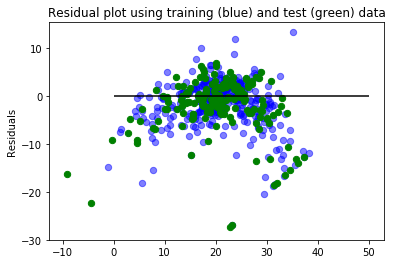

In [17]:
debug = False
num_of_iterations = 5000
alpha = 0.00001 # learning rate
batch_size = 50

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent_stochastic(batch_gen(X_train, y_train, batch_size), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

# Next steps

- Adding cost curves for a train/test data set
- Find which features are most important
- Incorporate a stopping condition
- Reduce dimensions

# Resources

- Variants of gradient descent: http://ruder.io/optimizing-gradient-descent/
- Optimisation by grid exhaustive search: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html (this is *often* used to *jointly* select the best parameters of a model, i.e. the best learning rate, number of steps, learning rate decay, ...)